In [1]:
import cv2
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Parse Annotations

In [2]:
data_dir = Path('../data/train/')
subset = 'a'
data_name = 'train_' + subset
gt_file = data_dir / '{}_annotations.json'.format(subset)

In [3]:
with open(str(gt_file), 'r') as f:
    gts = json.load(f)

imgs = gts['images']
annotations = gts['annotations']
categories = gts['categories']

In [4]:
num_classes = len(categories)
classes = []
class_ids = []
for category in categories:
    classes.append(category['name'])
    class_ids.append(category['id'])

class_ids = np.array(class_ids)
classes = np.array(classes)

### Display Number of Samples per Category

In [5]:
num_samples_per_class = np.zeros((num_classes), )
for ann in annotations:
    cid = ann['category_id']
    num_samples_per_class[cid] += 1

print('{} contains {} images, {} bboxes, {} categories'.format(data_name, len(imgs), len(annotations), len(np.nonzero(num_samples_per_class)[0])))

train_a contains 1458 images, 23617 bboxes, 113 categories


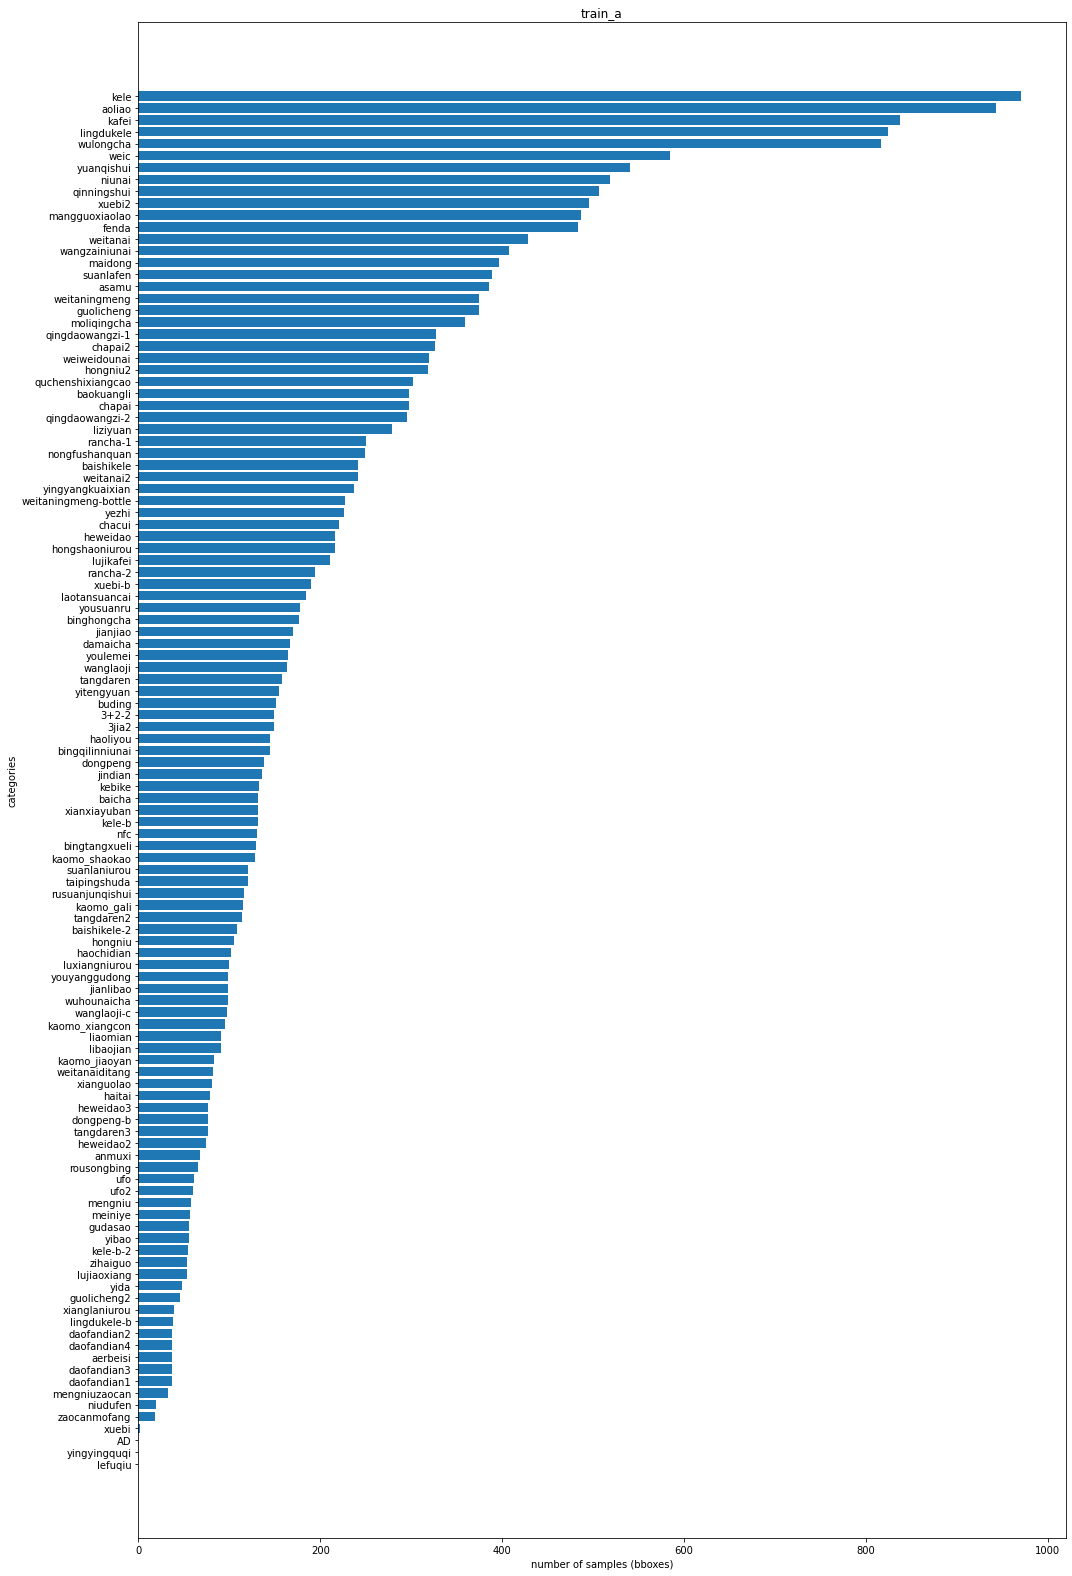

In [6]:
# change the figure size
plt.rcParams['figure.figsize'] = [15, 22]
fig, ax = plt.subplots()
sorted_ids = np.argsort(num_samples_per_class)
ax.barh(classes[sorted_ids], num_samples_per_class[sorted_ids])
ax.set_ylabel('categories')
ax.set_xlabel('number of samples (bboxes)')
plt.title(data_name)
fig.tight_layout()
plt.show()

### Display Annotation

In [7]:
def get_image_annotation(index):
    img_info = imgs[index]
    img_name = img_info['file_name']
    img_path = data_dir / '{}_images'.format(subset) / img_name
    img_id = img_info['id']
    bbox_list = []
    cls_list = []
    for gt in annotations:
        if gt['image_id'] == img_id:
            bbox = gt['bbox']
            cls_id = gt['category_id']
            bbox_list.append(bbox)
            cls_list.append(cls_id)
    return {'img_path': img_path, 'bbox_list': bbox_list, 'cls_list': cls_list}

In [8]:
colors = np.random.randint(0, 255, size=(classes.shape[0], 3), dtype=np.uint8)
def show_example(example_index):
    gt_dict = get_image_annotation(example_index)
    img_path = gt_dict['img_path']
    bbox_list = gt_dict['bbox_list']
    cls_list = gt_dict['cls_list']
    img = cv2.imread(str(img_path))
    for i, bbox in enumerate(bbox_list):
        cls_id = cls_list[i]
        cls_name = classes[cls_id]
        x1, y1, w, h = bbox
        color = colors[cls_id].tolist()
        cv2.rectangle(img, (x1, y1), (x1+w, y1+h), color, 3)
        cv2.putText(img, cls_name, (x1+10, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    print(img.shape)
    plt.show()
        

(720, 960, 3)


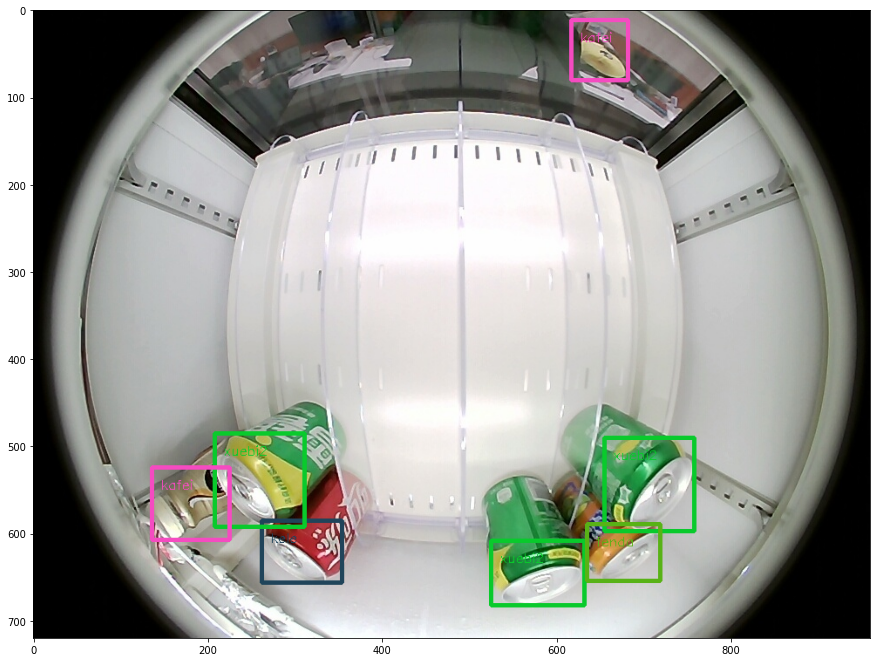

In [9]:
show_example(30)

### Statistics of bounding boxes

In [10]:
# image size: 720 x 960
num_crowd = 0
size_list = []
for ann in annotations:
    iscrowd = int(ann['iscrowd']) == 1
    if iscrowd:
        num_crowd += 1
        continue
    x, y, w, h = ann['bbox']
    size_list.append([w, h])

size_arr = np.array(size_list)

(array([2.8560e+03, 1.4389e+04, 4.4440e+03, 1.1990e+03, 3.3600e+02,
        2.1800e+02, 1.0400e+02, 5.8000e+01, 1.3000e+01]),
 array([ 20.        ,  61.44444444, 102.88888889, 144.33333333,
        185.77777778, 227.22222222, 268.66666667, 310.11111111,
        351.55555556, 393.        ]),
 <BarContainer object of 9 artists>)

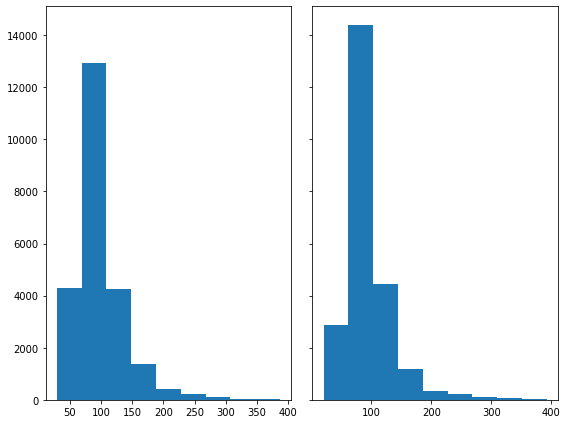

In [11]:
n_bins = 9
ws = size_arr[:,0]
hs = size_arr[:,1]
# change the figure size
plt.rcParams['figure.figsize'] = [8, 6]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(ws, bins=n_bins)
axs[1].hist(hs, bins=n_bins)

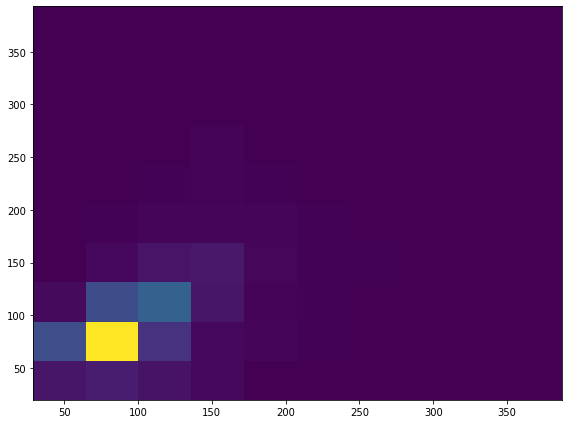

In [12]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(ws, hs)

In [13]:
# copied from https://github.com/lars76/kmeans-anchor-boxes
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [14]:
# https://zhuanlan.zhihu.com/p/231168560
# 聚类的数目
CLUSTERS = 6
# 模型中图像的输入尺寸，默认是一样的
H, W = [720.0, 960.0]
Ht, Wt = [416.0, 416.0]

out = kmeans(size_arr, k=CLUSTERS)

print('Original bbox clusters:')
idx = np.argsort(out[:,0])[::-1]
print(out[idx])
print("Accuracy: {:.2f}%".format(avg_iou(size_arr, out) * 100))

out = out.astype(np.float32)
out[:, 0] *= Wt / W
out[:, 1] *= Ht / H

out = out.astype(np.int32)
idx = np.argsort(out[:,0])[::-1]
out = out[idx]
print('YOLO anchors:')
print(out)

ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
print("Ratios:\n {}".format(sorted(ratios)))

Original bbox clusters:
[[169 173]
 [125 116]
 [112  56]
 [ 95  98]
 [ 81  79]
 [ 64  67]]
Accuracy: 81.92%
YOLO anchors:
[[73 99]
 [54 67]
 [48 32]
 [41 56]
 [35 45]
 [27 38]]
Ratios:
 [0.71, 0.73, 0.74, 0.78, 0.81, 1.5]
